# Assignment 4 - Temporal Difference Learning
### WS 2021

---
<div class="alert alert-warning">
    <b>Due:</b> See Moodle
</div>

<div class="alert alert-info">

In the second assignment, you will implement algorithms that were presented in the first lecture on temporal difference methods. You can gain 17 points in total. Please make sure that you do not overlook any of the questions.

<br>

To complete this exercise, read the notebook carefully from beginning to end and fill out coding parts and answer questions marked with **TODO**.

<br>

To make sure you do not forget any **TODO**s in this rather long notebook, here is a list:

- (1) Implement TD(0) (Policy Evaluation) (2 Points)
- (2) Implement SARSA (Policy Improvement) (3 Points)
- (3) Implement Q-Learning (Policy Improvement) (5 Points)
- (4) Implement Expected-SARSA (Policy Improvement) (5 Points)
- (5) Questions (2 Points)

**Do not forget to run all the code cells, before saving and submitting the assignment!**

# Temporal Difference Learning
We will use the `Cliff` environment as featured in the book. It is designed to illustrate the differences of different temporal difference learning methods. You will need to implement evaluation and control algorithms.

## (1) TD(0) policy evaluation (2 points)

We will use an external library here, that you got when you downloaded the assingment from MOODLE. The directory `gym_gridworlds` should be a subdirectory of the folder that you started the Jupyter notebook server in.

Your first task is to implement the TD(0) policy evaluation algorithm.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from collections import defaultdict
import gym_gridworlds as gg
np.set_printoptions(linewidth=200)

In [2]:
def td_policy_evaluation(env, policy, num_episodes, gamma=0.999, alpha=0.1):
    V = defaultdict(lambda: 0)
    actions = np.arange(env.action_space.n)
    rng = np.random.default_rng()
    for si in range(1, num_episodes + 1):
        s = env.reset()
        done = False
        
        while not done:
            s = int(s)
            # choose action by a policy for given state s:
            policy_current_state = policy[s]
            action_array = rng.multinomial(1, policy_current_state)
            action = np.where(action_array==1)[0][0] # action is chosen. of course we have no dynamcis knowledge,
            # which could influence know:
            
            # Act chosen action to get reward and future state:          
            happening_array = np.array(env.P[s][action])
            happening_probabilities = happening_array[:,0]
            happening_future_states = rng.multinomial(1, happening_probabilities)
            happening_future_choose  = np.where(happening_future_states==1)[0][0]
            
            happening_future_tuple = happening_array[happening_future_choose]
            _, future_state, reward, done = happening_future_tuple # done: does our episode reach an end
            # or do we have to go further with the while loop
            
            # Compute V:
            V[s] = V[s] + alpha * (reward + gamma*V[int(future_state)] - V[s])
            
            # Go to next state while episode not done:
            s = future_state
            
            
        # TODO
    return V

### Now let's try TD(0) to evaluate the random policy


FFFFFFFFFFFF
FFFFFFFFFFFF
FFFFFFFFFFFF
SHHHHHHHHHHG


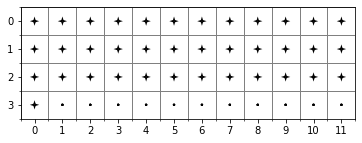

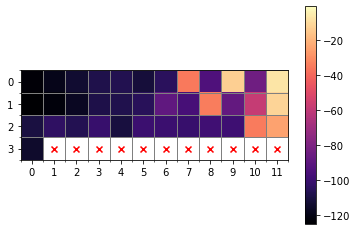

In [3]:
cliff_env = gym.make('Cliff-v0')
cliff_env.render()

num_episodes = 1000
alpha = 0.9
gamma = 0.999
epsilon = 0.1

policy = gg.random_policy(cliff_env)
V = td_policy_evaluation(cliff_env, policy, num_episodes=num_episodes, gamma=gamma, alpha=alpha)

gg.plot_policy(cliff_env, policy)
gg.plot_value_function(cliff_env, V, vmax=-1)

In [4]:
# a helper functions that define epsilon greedy policies from Q values.
# this function breaks ties uniformly at random (if qs are all equal)
# you should use it where appropriate!
def eps_greedy_from_qs(rng, qs, epsilon):
    # find all currently optimal actions
    optimal_actions = np.argwhere(qs == np.amax(qs))
    
    # choose any of the optimal actions uniformly at random
    optimal_action = rng.choice(optimal_actions)
    
    # build an eps-soft policy:
    
    # compute eps/A(s)
    eps_p = epsilon / len(qs)
    
    # fill empty array of the same shape as 'qs' with eps/|A(s)|
    ps = np.full_like(qs, eps_p)
    
    # assign most probability mass to optimal action
    ps[optimal_action] += 1 - epsilon
    return ps

## (2) SARSA (3 Points)
Your task is to implement SARSA, and test it on the Cliff environment.

In [5]:
def choosing_action_Q_epsilon_greedy(rng, Qs, epsilon):
    
    # Choose an action:
    policy_array = eps_greedy_from_qs(rng, Qs, epsilon) # get an array in which the action with
    # the highest value has the highest probability to be chosen
    action_array = rng.multinomial(1, policy_array) # choose an action relying on the probabilities
    # to be selecetd
    action = np.where(action_array==1)[0][0] 
    
    return action, policy_array

In [6]:
def sarsa(env, num_episodes, gamma, alpha, epsilon):
    # this is how we store the state-action value function
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # this is simply a helper array that helps us sample from available actions, given a policy
    actions = np.arange(env.action_space.n)
    # we'll not externally seed anything here, but still use the new PRNG API 
    rng = np.random.default_rng()
    for si in range(1, num_episodes + 1):
        if si % 10000 == 0:
            print('{}/{} Episodes'.format(si, num_episodes))

        s = env.reset()
        # TODO
        # a = ? -> a sample from an eps-greedy policy, based on the current Q values
        # you may want use the helper function defined above, to do this conveniently

        # Choose an action:
        
        action,_ = choosing_action_Q_epsilon_greedy(rng, Q[s], epsilon)
        done = False
        while not done:
            s = int(s) # transform to integer to use s as slicing index
            
            # Act chosen action to get reward and future state:          
            happening_array = np.array(env.P[s][action])
            happening_probabilities = happening_array[:,0]
            happening_future_states = rng.multinomial(1, happening_probabilities)
            happening_future_choose  = np.where(happening_future_states==1)[0][0]
            
            happening_future_tuple = happening_array[happening_future_choose]
            _, future_state, reward, done = happening_future_tuple # done: does our episode reach an end
            # or do we have to go further with the while loop
            
            
            # Choose future action in future_state:
            future_action,_ = choosing_action_Q_epsilon_greedy(rng, Q[int(future_state)], epsilon)
            
            # Update Q(s,a):
            Q[s][action] = Q[s][action] + alpha * (reward + gamma * Q[future_state][future_action] - Q[s][action])
            
            # Update s and a
            s, action = future_state, future_action
            # TODO

    # after all the episodes, there might be states missing from 'policy', as exploration
    # could have missed some states. so if we have not encountered a state yet, behave randomly
    policy = defaultdict(lambda: np.ones(env.action_space.n) / env.action_space.n)
    
    # make a deterministic policy, based on the Q values
    for s, qs in Q.items():
        policy[s] = np.eye(env.action_space.n)[np.argmax(qs)]
    return policy, Q

### Setup and Run


FFFFFFFFFFFF
FFFFFFFFFFFF
FFFFFFFFFFFF
SHHHHHHHHHHG


------------------------------
SARSA
num_episodes 10000
alpha 0.1
gamma 0.999
10000/10000 Episodes


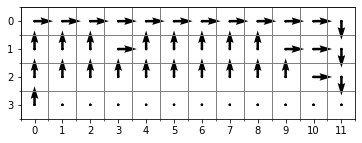

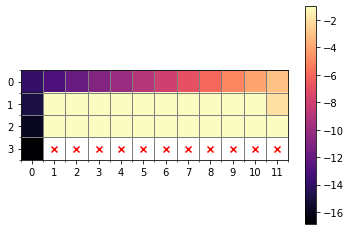

In [7]:
cliff_env = gym.make('Cliff-v0')
cliff_env.render()

num_episodes = 10000
alpha = 0.1
gamma = 0.999

# SARSA needs to explore a lot with this small amount of episodes
# if this is set too low, we'll end up with policies that will
# produce infinite loops, once we try to evaluate the policy with
# TD policy evaluation!
# (i.e. policies that loop between two or more states)
epsilon = 0.5

print('\n\n' + '-' * 30)
print('SARSA')
print('num_episodes', num_episodes)
print('alpha', alpha)
print('gamma', gamma)
policy, Q = sarsa(cliff_env, num_episodes, gamma=gamma, alpha=alpha, epsilon=epsilon)
V = td_policy_evaluation(cliff_env, policy, num_episodes, gamma=gamma, alpha=alpha)

gg.plot_policy(cliff_env, policy)
gg.plot_value_function(cliff_env, V, vmax=-1)

## (3) Q-Learning (5 points)
Your task is to implement Q-Learning, and test it on the `Cliff` environment.

In [8]:
def q_learning(env, num_episodes, gamma, alpha, epsilon):
    # TODO (look at SARSA to get started)
    
    # Only slight change in the 
     # this is how we store the state-action value function
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # this is simply a helper array that helps us sample from available actions, given a policy
    actions = np.arange(env.action_space.n)
    # we'll not externally seed anything here, but still use the new PRNG API 
    rng = np.random.default_rng()
    for si in range(1, num_episodes + 1):
        if si % 10000 == 0:
            print('{}/{} Episodes'.format(si, num_episodes))

        s = env.reset()
        # TODO
        # a = ? -> a sample from an eps-greedy policy, based on the current Q values
        # you may want use the helper function defined above, to do this conveniently

        # Choose an action:
        
        
        done = False
        while not done:
            s = int(s) # transform to integer to use s as slicing index
            
            # SARSA difference: action computation shifted here:
            action,_ = choosing_action_Q_epsilon_greedy(rng, Q[s], epsilon)
            
            # Act chosen action to get reward and future state:          
            happening_array = np.array(env.P[s][action])
            happening_probabilities = happening_array[:,0]
            happening_future_states = rng.multinomial(1, happening_probabilities)
            happening_future_choose  = np.where(happening_future_states==1)[0][0]
            
            happening_future_tuple = happening_array[happening_future_choose]
            _, future_state, reward, done = happening_future_tuple # done: does our episode reach an end
            # or do we have to go further with the while loop
            
            # Here is only difference to SARSA:
            # Take the highest action value for the future state:
            best_Q_next_state = np.max(Q[int(future_state)])
            
            # Little change compared to SARSA:
            # Update Q(s,a):
            Q[s][action] = Q[s][action] + alpha * (reward + gamma * best_Q_next_state - Q[s][action])
            
            # Update s and a
            s = future_state
            # TODO

    # after all the episodes, there might be states missing from 'policy', as exploration
    # could have missed some states. so if we have not encountered a state yet, behave randomly
    policy = defaultdict(lambda: np.ones(env.action_space.n) / env.action_space.n)
    
    # make a deterministic policy, based on the Q values
    for s, qs in Q.items():
        policy[s] = np.eye(env.action_space.n)[np.argmax(qs)]
    return policy, Q


### Setup and Run


FFFFFFFFFFFF
FFFFFFFFFFFF
FFFFFFFFFFFF
SHHHHHHHHHHG


------------------------------
Q-Learning
num_episodes 1000
alpha 0.9
gamma 0.999


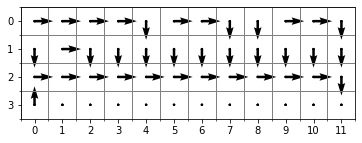

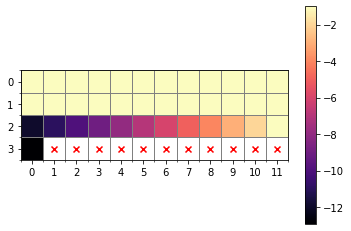

In [9]:
cliff_env = gym.make('Cliff-v0')
cliff_env.render()

num_episodes = 1000
alpha = 0.9
gamma = 0.999
epsilon = 0.1

print('\n\n' + '-' * 30)
print('Q-Learning')
print('num_episodes', num_episodes)
print('alpha', alpha)
print('gamma', gamma)

policy, Q = q_learning(cliff_env, num_episodes, gamma=gamma, alpha=alpha, epsilon=epsilon)
V = td_policy_evaluation(cliff_env, policy, num_episodes, gamma=gamma)

gg.plot_policy(cliff_env, policy)
gg.plot_value_function(cliff_env, V, vmax=-1)

## (4) Expected SARSA (5 points)

In [10]:
def expected_sarsa(env, num_episodes, gamma, alpha, epsilon):
    # TODO (look at SARSA to get started)
    
    # Only slight change in the 
    # this is how we store the state-action value function
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # this is simply a helper array that helps us sample from available actions, given a policy
    actions = np.arange(env.action_space.n)
    # we'll not externally seed anything here, but still use the new PRNG API 
    rng = np.random.default_rng()
    for si in range(1, num_episodes + 1):
        if si % 10000 == 0:
            print('{}/{} Episodes'.format(si, num_episodes))

        s = env.reset()
        # TODO
        # a = ? -> a sample from an eps-greedy policy, based on the current Q values
        # you may want use the helper function defined above, to do this conveniently

        
        done = False
        while not done:
            s = int(s) # transform to integer to use s as slicing index
            
            # SARSA difference: action computation shifted here:
            action,_ = choosing_action_Q_epsilon_greedy(rng, Q[s], epsilon)
            
            # Act chosen action to get reward and future state:          
            happening_array = np.array(env.P[s][action])
            happening_probabilities = happening_array[:,0]
            happening_future_states = rng.multinomial(1, happening_probabilities)
            happening_future_choose  = np.where(happening_future_states==1)[0][0]
            
            happening_future_tuple = happening_array[happening_future_choose]
            _, future_state, reward, done = happening_future_tuple # done: does our episode reach an end
            # or do we have to go further with the while loop
            
            
            # Use a second policy to when looking at the future state and its possible values:
            # Here we use the random policy. Therefore, each action gets the same weight:
            _, future_pol = choosing_action_Q_epsilon_greedy(rng, Q[int(future_state)], epsilon)

            future_state_Q_sum = np.sum(Q[int(future_state)] * future_pol )
            
            # Update Q(s,a):
            Q[s][action] = Q[s][action] + alpha * (reward + gamma * future_state_Q_sum - Q[s][action])
            
            # Update s and a
            s = future_state
            # TODO

    # after all the episodes, there might be states missing from 'policy', as exploration
    # could have missed some states. so if we have not encountered a state yet, behave randomly
    policy = defaultdict(lambda: np.ones(env.action_space.n) / env.action_space.n)
    
    # make a deterministic policy, based on the Q values
    for s, qs in Q.items():
        policy[s] = np.eye(env.action_space.n)[np.argmax(qs)]
    return policy, Q
    return None

### Setup and Run


FFFFFFFFFFFF
FFFFFFFFFFFF
FFFFFFFFFFFF
SHHHHHHHHHHG


------------------------------
Expected SARSA
num_episodes 1000
alpha 0.9
gamma 0.999


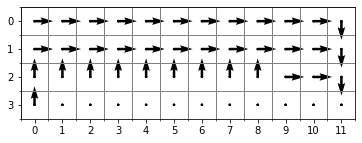

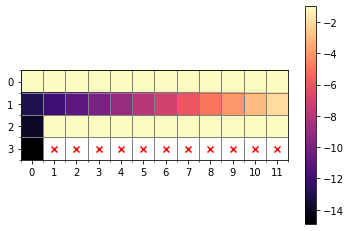

In [11]:
cliff_env = gym.make('Cliff-v0')
cliff_env.render()

# aha - this is interesting! expected SARSA needs much less episodes
# than SARSA!
num_episodes = 1000
alpha = 0.9
gamma = 0.999
epsilon = 0.1

### Run Algorithm

print('\n\n' + '-' * 30)
print('Expected SARSA')
print('num_episodes', num_episodes)
print('alpha', alpha)
print('gamma', gamma)
policy, Q = expected_sarsa(cliff_env, num_episodes, gamma=gamma, alpha=alpha, epsilon=epsilon)

V = td_policy_evaluation(cliff_env, policy, num_episodes, gamma=gamma)

gg.plot_policy(cliff_env, policy)
gg.plot_value_function(cliff_env, V, vmax=-1)

## (5) Questions (2 points)
Look at the policies and associated value functions that SARSA, Q-Learning and Expected SARSA produced, and briefly describe the different policies that the respective algorithms found.
- Why there are differences?
- Which algorithm produced the optimal policy?

(You may want to consult the book, Example 6.6 if you are stuck.)

**Answer**: The SARSA policy prefers keeping a maximal distance to the dangerous cliff. It prefers the longest route up to the goal state. Q-learning considers the highest rewarded action next after the current action. Therefore, the risk of dying thorugh the cliff doesn't get as much weight as in the case of SARSA such that the shortest possible route (which is the most dangerous one) is prefered. The policy for Expected SARSA focuses on not being on the neighbouring path of the cliff. When accidently ending up on the path/row furthest away from cliff, the policy also accepts in going that path further instead of leaving it intentionally. <br><br>
The differences are because:<br>
All algorithms have a look at the Q(S', A'). So not only the current state-action-pair is considered but also the upcoming ones in the case of choosing the concrete current state-action-pair. However, the algorithms have different strategies: <br>
In this case SARSA chooses only one action a' (here epsilon-greedy). Therefore, it can happen that the agent explores and dies in the cliff. So, it is learnt to keep maximal distance of the cliff in that small state space.<br>
Q-Learning however then chooses always the highest scoring action. Therefore, the danger of dying in the cliff isn't considered. The shortest path to the goal state nearby the cliff is chosen. <br>
Expected SARSA considers a weighted sum of the values for all possible a'-s. So, the algorithm can better estimate the real risk of each state in the field. That's why the path nearby the cliff is avoided.<br><br>
Expected SARSA has produced the best policy because there is a trade-off between risk consideration and fastest way to goal state. This counts for the case when there is a risk of drifting accidently into the cliff. (When this risk wouldn't be given then Q-Learning policy would be the best.)